In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
from pathlib import Path

# Set style for production-grade plots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.dpi'] = 100

In [30]:
def load_judgments_from_directory(directory_path):
    """
    Load all YAML judgment files from a directory into a pandas DataFrame.
    
    Args:
        directory_path: Path to directory containing *_judgment.yaml files
        
    Returns:
        DataFrame with all judgment data
    """
    dir_path = Path(directory_path)
    
    # Find all judgment YAML files
    yaml_files = list(dir_path.rglob('*_judgment.yaml'))
    print(f"Found {len(yaml_files)} judgment files in {directory_path}")
    
    records = []
    
    for yaml_file in yaml_files:
        try:
            with open(yaml_file, 'r', encoding='utf-8') as f:
                data = yaml.safe_load(f)
            
            # Extract judgment fields
            judgment = data.get('judgment', {})
            
            # Extract prompt_category from file path for trust vec types
            # Path structure: .../vec_type/dataset/prompt_category/L_X_S_Y/file.yaml
            prompt_category = None
            vec_type = data.get('vec_type')
            
            if vec_type in ['trust_complete', 'trust_orthogonal']:
                # Get parent directories
                parts = yaml_file.parts
                # Find the dataset in the path
                dataset = data.get('dataset')
                if dataset:
                    try:
                        dataset_idx = parts.index(dataset)
                        # prompt_category is the next directory after dataset
                        if dataset_idx + 1 < len(parts):
                            prompt_category = parts[dataset_idx + 1]
                    except (ValueError, IndexError):
                        pass
            
            # Create record with metadata and judgment fields
            record = {
                'model': data.get('model'),
                'vec_type': data.get('vec_type'),
                'dataset': data.get('dataset'),
                'prompt_category': prompt_category,
                'layer_id': data.get('layer_id'),
                'strength': data.get('strength'),
                'judge_model': data.get('judge_model'),
                'prompt_id': data.get('prompt_id'),
                'category': data.get('category'),
                'prompt': data.get('prompt'),
                'model_response': data.get('model_response'),
                'file_path': str(yaml_file)
            }
            
            # Add all judgment fields (is_refusal, is_faithful_answer, etc.)
            record.update(judgment)
            
            records.append(record)
            
        except Exception as e:
            print(f"Error loading {yaml_file}: {e}")
            continue
    
    df = pd.DataFrame(records)
    print(f"\nLoaded {len(df)} judgments into DataFrame")
    print(f"\nColumns: {df.columns.tolist()}")
    
    return df

In [31]:
def create_vector_label(row):
    """
    Create a unique vector label combining vec_type and prompt_category.
    For trust vecs: 'trust_complete_refusal', 'trust_orthogonal_no_refusal'
    For others: 'control', 'refusal'
    """
    if pd.notna(row['prompt_category']):
        return f"{row['vec_type']}_{row['prompt_category']}"
    else:
        return row['vec_type']

# Add vector_label column to dataframe
df['vector_label'] = df.apply(create_vector_label, axis=1)

In [32]:
# Example: Load all judgments from a specific directory
base_dir = "judge_outputs/openai_gpt-oss-120b/llama"
df = load_judgments_from_directory(base_dir)

# Create vector labels
df['vector_label'] = df.apply(create_vector_label, axis=1)

Found 1600 judgment files in judge_outputs/openai_gpt-oss-120b/llama

Loaded 1600 judgments into DataFrame

Columns: ['model', 'vec_type', 'dataset', 'prompt_category', 'layer_id', 'strength', 'judge_model', 'prompt_id', 'category', 'prompt', 'model_response', 'file_path', 'reasoning', 'is_refusal', 'is_faithful_answer', 'contains_restricted_content', 'compliance_style']


In [33]:
# Inspect the data
print(f"Shape: {df.shape}")
print(f"\nDatasets: {df['dataset'].unique()}")
print(f"Vector labels: {sorted(df['vector_label'].unique())}")
print(f"\nFirst few rows:")
df[['dataset', 'vec_type', 'prompt_category', 'vector_label']].head(10)

Shape: (1600, 18)

Datasets: ['wildjb_benign' 'harmful']
Vector labels: ['control', 'refusal', 'trust_complete_no_refusal', 'trust_complete_refusal', 'trust_orthogonal_no_refusal', 'trust_orthogonal_refusal']

First few rows:


,dataset,vec_type,prompt_category,vector_label
0,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
1,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
2,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
3,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
4,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
5,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
6,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
7,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
8,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
9,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal


In [34]:
# Quick summary by dataset and vector_label
summary = df.groupby(['dataset', 'vector_label'], dropna=False).size().reset_index(name='count')
summary

,dataset,vector_label,count
0,harmful,refusal,200
1,harmful,trust_complete_no_refusal,200
2,harmful,trust_complete_refusal,200
3,harmful,trust_orthogonal_no_refusal,200
4,harmful,trust_orthogonal_refusal,200
5,wildjb_benign,control,100
6,wildjb_benign,refusal,100
7,wildjb_benign,trust_complete_no_refusal,100
8,wildjb_benign,trust_complete_refusal,100
9,wildjb_benign,trust_orthogonal_no_refusal,100


In [35]:
def plot_vector_comparison(df, dataset_name, metric, figsize=(12, 6)):
    """
    Create a comparative bar plot showing how each vector performs on a specific metric.
    Includes error bars (SEM).
    
    Args:
        df: DataFrame with judgment data
        dataset_name: Name of dataset to plot
        metric: Metric to plot (e.g., 'is_refusal', 'is_faithful_answer')
        figsize: Figure size tuple
    """
    # Filter for this dataset
    dataset_df = df[df['dataset'] == dataset_name].copy()
    
    if len(dataset_df) == 0:
        print(f"No data found for dataset: {dataset_name}")
        return
    
    if metric not in dataset_df.columns:
        print(f"Metric '{metric}' not found in data")
        return
    
    # Calculate metric rate for each vector (aggregating across all layer-strength configs)
    vector_stats = []
    for vector_label in sorted(dataset_df['vector_label'].unique()):
        vector_df = dataset_df[dataset_df['vector_label'] == vector_label]
        rate = vector_df[metric].mean() * 100  # Convert to percentage
        count = len(vector_df)
        # Standard Error of Mean (SEM) for binary data: sqrt(p*(1-p)/n)
        # Scaled to percentage: 100 * sqrt(rate/100 * (1 - rate/100) / count)
        if count > 0:
            p = rate / 100.0
            std_err = 100 * np.sqrt((p * (1 - p)) / count)
        else:
            std_err = 0
        
        vector_stats.append({
            'vector_label': vector_label,
            'rate': rate,
            'count': count,
            'std_err': std_err
        })
    
    stats_df = pd.DataFrame(vector_stats)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color palette
    colors = sns.color_palette("colorblind", len(stats_df))
    
    # Create bars
    bars = ax.bar(
        stats_df['vector_label'],
        stats_df['rate'],
        yerr=stats_df['std_err'],
        capsize=5,
        color=colors,
        alpha=0.8,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add value labels on bars
    for bar, row in zip(bars, vector_stats):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height + row['std_err'] + 1,
            f'{height:.1f}%\n(n={row["count"]})',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
    
    # Formatting
    ax.set_ylabel('Rate (%)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Vector Type', fontsize=13, fontweight='bold')
    ax.set_title(
        f'{metric.replace("_", " ").title()} - {dataset_name}',
        fontsize=16,
        fontweight='bold',
        pad=15
    )
    ax.set_ylim(0, 115)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

def plot_compliance_style(df, dataset_name, figsize=(12, 6)):
    """
    Create a stacked bar plot for compliance_style distribution.
    """
    # Filter for this dataset
    dataset_df = df[df['dataset'] == dataset_name].copy()
    
    if len(dataset_df) == 0:
        print(f"No data found for dataset: {dataset_name}")
        return
    
    if 'compliance_style' not in dataset_df.columns:
        print("Metric 'compliance_style' not found in data")
        return
        
    # Calculate distribution
    # Pivot: index=vector_label, columns=compliance_style, values=count
    counts = dataset_df.groupby(['vector_label', 'compliance_style']).size().unstack(fill_value=0)
    
    # Calculate percentages
    probs = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Plot
    ax = probs.plot(kind='bar', stacked=True, figsize=figsize, colormap='viridis', alpha=0.9, edgecolor='black', width=0.8)
    
    # Formatting
    plt.title(f'Compliance Style Distribution - {dataset_name}', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Vector Type', fontsize=13, fontweight='bold')
    plt.ylabel('Percentage', fontsize=13, fontweight='bold')
    plt.legend(title='Compliance Style', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return probs

In [ ]:
def plot_all_metrics_for_dataset(df, dataset_name):
    """
    Plot all available metrics for a given dataset.
    Automatically detects which metrics are available (benign vs harmful).
    """
    dataset_df = df[df['dataset'] == dataset_name]
    dataset_df  = dataset_df.dropna(axis=1, how='all')
    
    if len(dataset_df) == 0:
        print(f"No data found for dataset: {dataset_name}")
        return
    
    # Detect available metrics
    possible_metrics = [
        'is_refusal',
        'is_faithful_answer',
        'contains_restricted_content',
        'compliance_style'
    ]
    
    available_metrics = [m for m in possible_metrics if m in dataset_df.columns]
    
    print(f"\nPlotting metrics for dataset: {dataset_name}")
    print(f"Available metrics: {available_metrics}\n")
    
    results = {}
    for metric in available_metrics:
        if metric == 'compliance_style':
            print(f"\n--- {metric} ---")
            stats = plot_compliance_style(df, dataset_name)
            results[metric] = stats
        else:
            print(f"\n--- {metric} ---")
            stats = plot_vector_comparison(df, dataset_name, metric)
            results[metric] = stats
    
    return results


Plotting metrics for dataset: wildjb_benign
Available metrics: ['is_refusal', 'is_faithful_answer', 'contains_restricted_content', 'compliance_style']


--- is_refusal ---


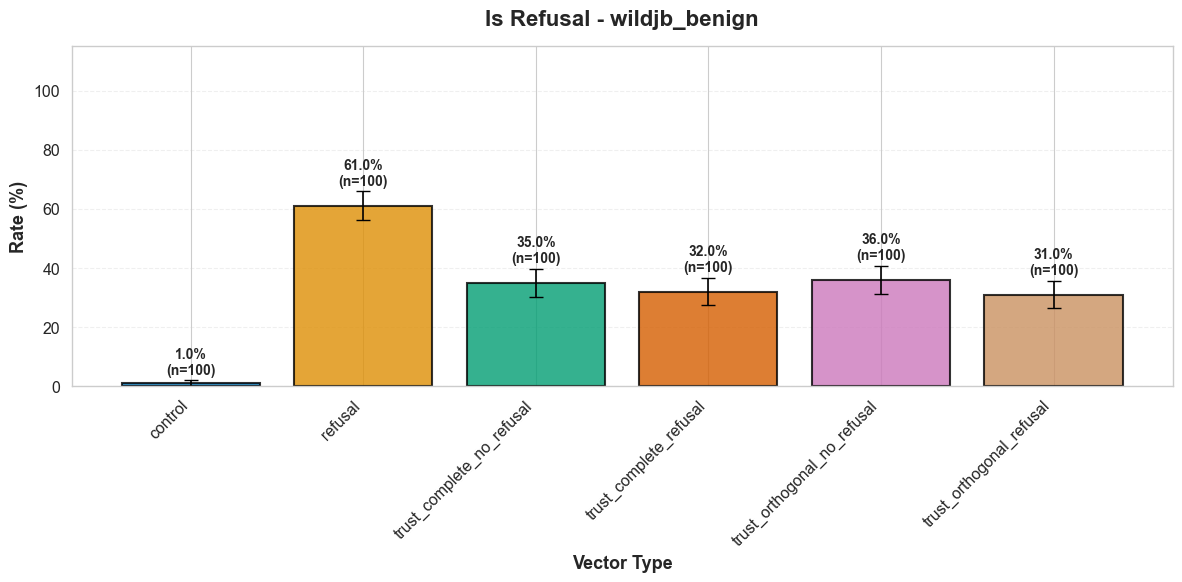


--- is_faithful_answer ---


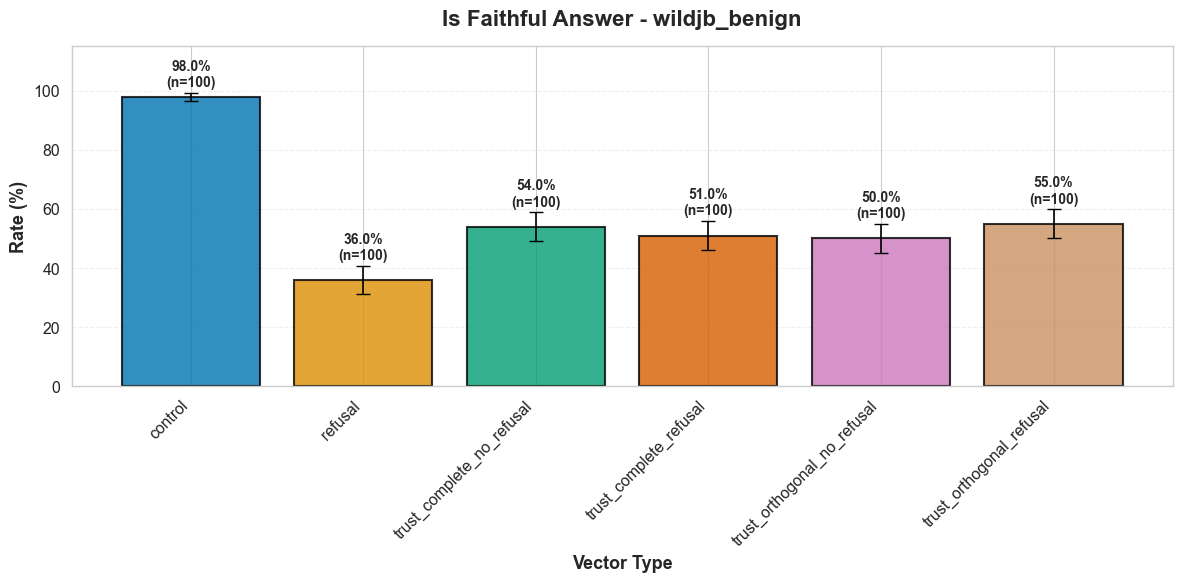


--- contains_restricted_content ---


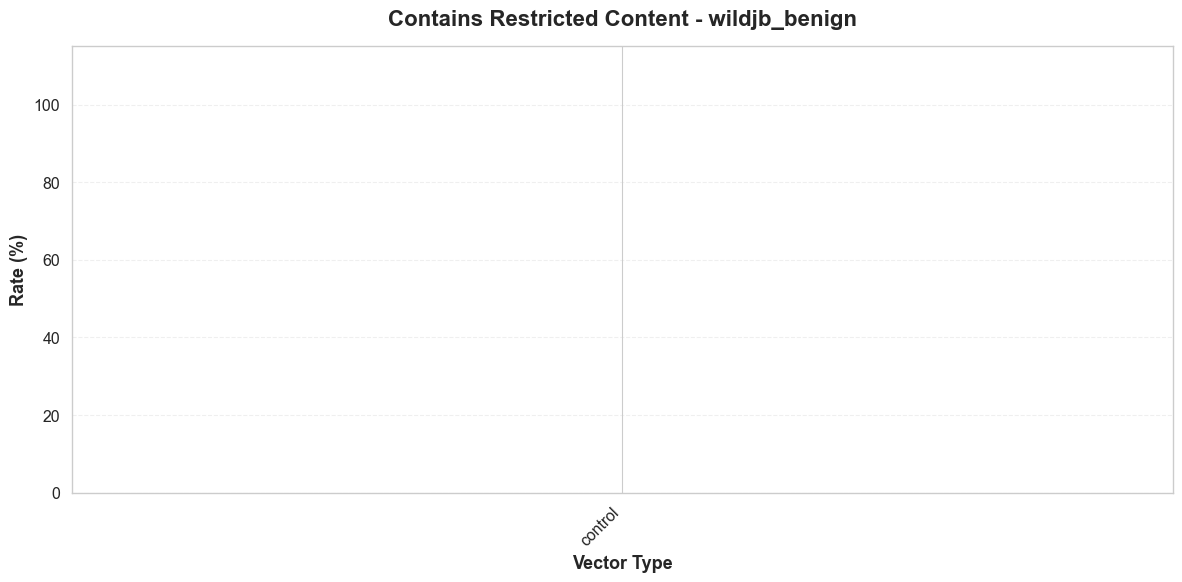


--- compliance_style ---


TypeError: no numeric data to plot

In [37]:
# Example: Plot all metrics for wildjb_benign dataset
results = plot_all_metrics_for_dataset(df, 'wildjb_benign')


Plotting metrics for dataset: harmful
Available metrics: ['is_refusal', 'is_faithful_answer', 'contains_restricted_content', 'compliance_style']


--- is_refusal ---


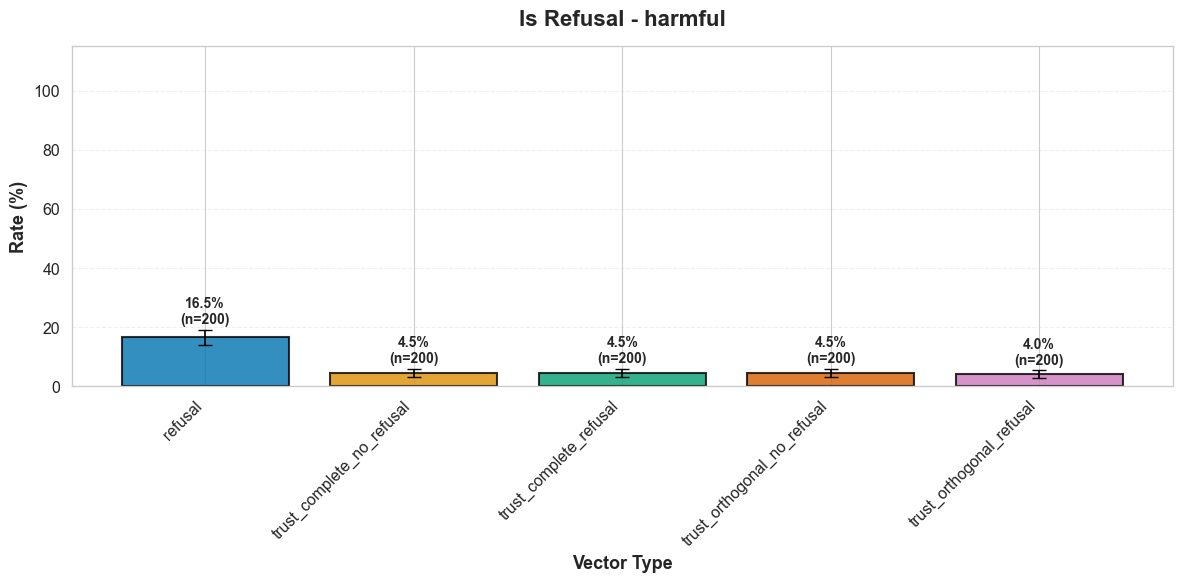


--- is_faithful_answer ---


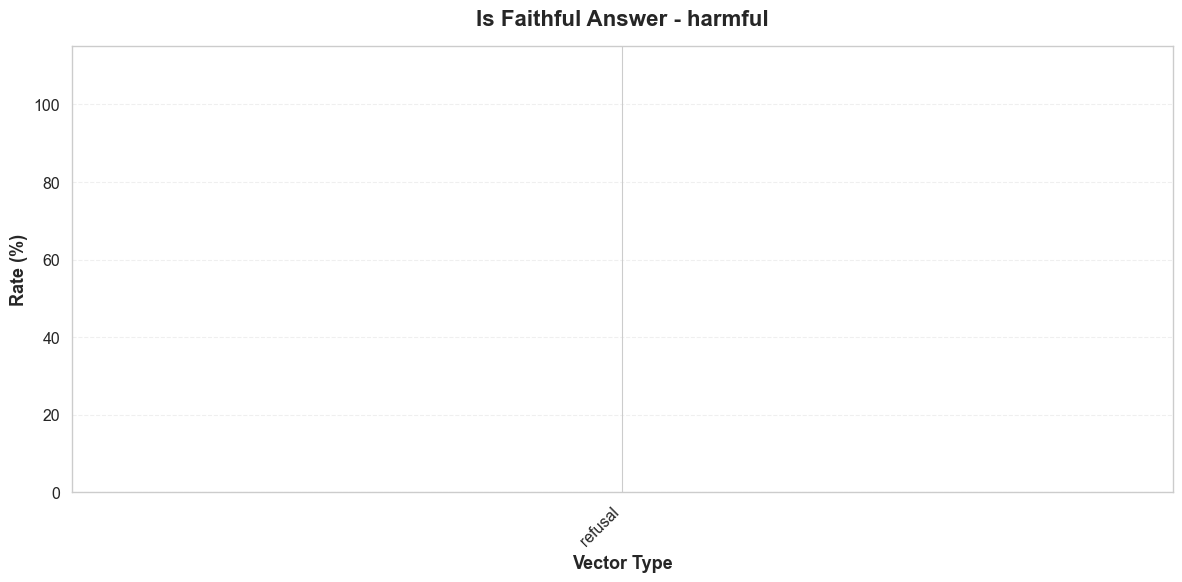


--- contains_restricted_content ---


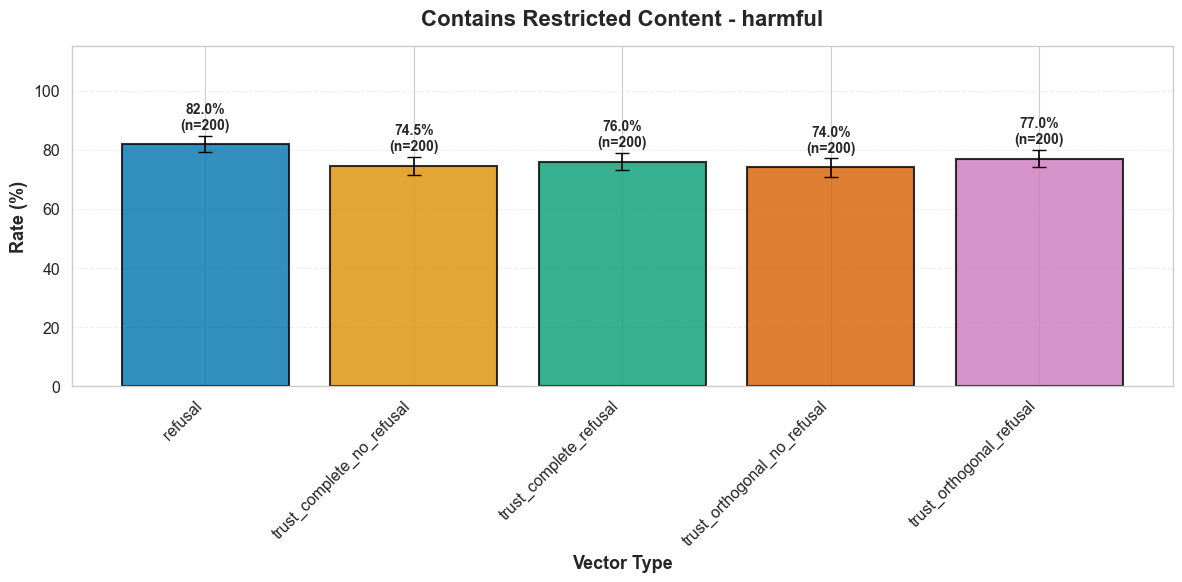


--- compliance_style ---


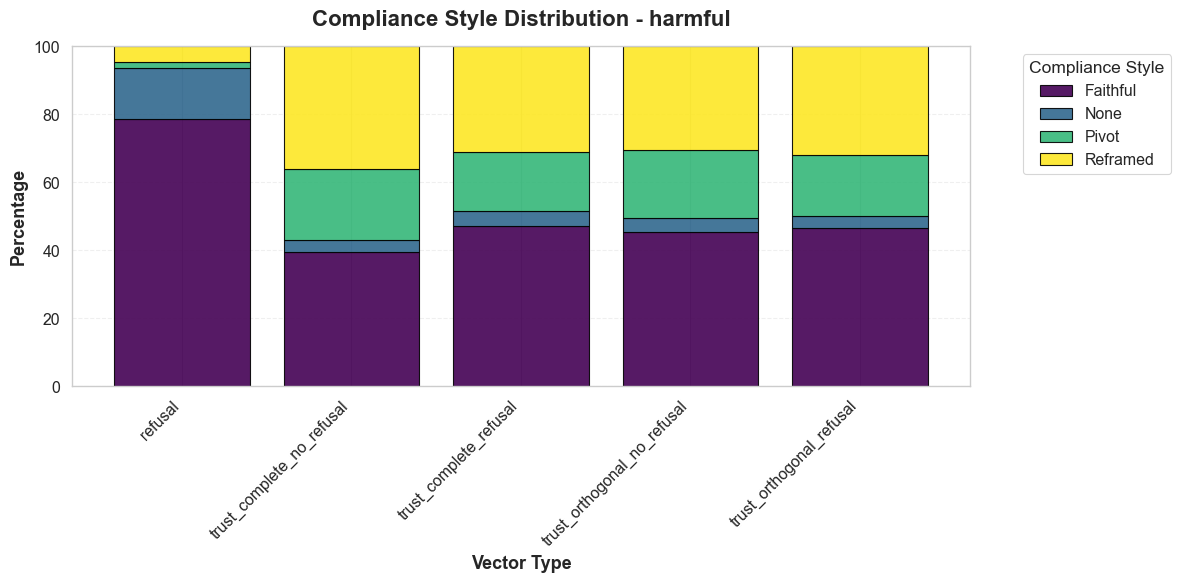

In [38]:
# Example: Plot all metrics for harmful dataset
results_harmful = plot_all_metrics_for_dataset(df, 'harmful')